# Analyze Transformer Models

## Load the Predictions

In [1]:
import numpy as np
import pandas as pd
import respiration.utils as utils

signals_path = utils.file_path('outputs', 'signals')
predictions_path = utils.join_paths(signals_path, 'transformer_predictions.csv')

prediction = pd.read_csv(predictions_path)
prediction['signal'] = prediction['signal'].apply(eval).apply(np.array)

In [2]:
prediction.head()

,model,subject,setting,duration,signal
0,20240511_194544,Proband01,101_natural_lighting,0 days 00:00:01.582158,"[0.00039531197398900986, 0.0033566197380423546..."
1,20240511_190518,Proband01,101_natural_lighting,0 days 00:00:01.591153,"[0.0029753046110272408, 0.003130626864731312, ..."
2,20240511_194544,Proband02,101_natural_lighting,0 days 00:00:01.593130,"[0.002729683183133602, 0.004241614602506161, 0..."
3,20240511_190518,Proband02,101_natural_lighting,0 days 00:00:01.591145,"[0.00292003620415926, -0.0018318099901080132, ..."
4,20240511_194544,Proband03,101_natural_lighting,0 days 00:00:01.594567,"[0.00039146747440099716, -0.000941650010645389..."


## Get the Ground Truth RR Signal

In [3]:
ground_truth_file = utils.join_paths(signals_path, 'respiration_gt.csv')
ground_truth = pd.read_csv(ground_truth_file)
ground_truth['signal'] = ground_truth['signal'].apply(eval).apply(np.array)
ground_truth.head()

,subject,setting,signal
0,Proband01,101_natural_lighting,"[6059.713310369678, 6680.352219172085, 6483.68..."
1,Proband02,101_natural_lighting,"[-32.842349471658856, -2038.812437786393, -133..."
2,Proband03,101_natural_lighting,"[-1296.558040724748, -782.3809097047636, -954...."
3,Proband04,101_natural_lighting,"[1959.6682933757063, 2771.8349143575556, 2765...."
4,Proband05,101_natural_lighting,"[-1583.2997360384775, -261.8138707427685, -822..."


## Analyze the Performance of the Model

In [4]:
models = prediction['model'].unique()
models

array(['20240511_194544', '20240511_190518'], dtype=object)

In [5]:
# The testing scenarios are the same for each model
manifest_path = utils.file_path('models', 'transformer', '20240511_190518', 'manifest.json')
manifest = utils.read_json(manifest_path)
testing_scenarios = manifest['testing_scenarios']
testing_scenarios

[['Proband21', '101_natural_lighting'],
 ['Proband22', '101_natural_lighting'],
 ['Proband23', '101_natural_lighting'],
 ['Proband24', '101_natural_lighting'],
 ['Proband25', '101_natural_lighting'],
 ['Proband26', '101_natural_lighting']]

In [6]:
import os
from tqdm.auto import tqdm
import respiration.analysis as analysis

analysis_dir = utils.dir_path('outputs', 'analysis', mkdir=True)
analysis_file = os.path.join(analysis_dir, 'transformer_analysis.csv')

if os.path.exists(analysis_file):
    analysis_results = pd.read_csv(analysis_file)
else:
    analysis_results = []

    for model_id in tqdm(models):
        for (subject, setting) in testing_scenarios:
            scenario = prediction[(prediction['model'] == model_id) &
                                  (prediction['subject'] == subject) &
                                  (prediction['setting'] == setting)].iloc[0]
            prediction_signal = scenario['signal']

            scenario_gt = ground_truth[(ground_truth['subject'] == subject) &
                                       (ground_truth['setting'] == setting)].iloc[0]

            # Cut the signal to the same length
            gt_signal = scenario_gt['signal'][1:len(prediction_signal) + 1]

            comparator = analysis.SignalComparator(
                prediction_signal,
                gt_signal,
                30,
            )

            for metric, result in comparator.all_results().items():
                analysis_results.append({
                    'model_id': model_id,
                    'subject': subject,
                    'setting': setting,
                    'metric': metric,
                    'prediction': result['prediction'],
                    'ground_truth': result['ground_truth'],
                })

    analysis_results = pd.DataFrame(analysis_results)
    analysis_results.to_csv(analysis_file, index=False)

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
analysis_results.head()

,model_id,subject,setting,metric,prediction,ground_truth
0,20240511_194544,Proband21,101_natural_lighting,pk,29.0,26.0
1,20240511_194544,Proband21,101_natural_lighting,cp,33.0,26.0
2,20240511_194544,Proband21,101_natural_lighting,nfcp,35.0,28.0
3,20240511_194544,Proband21,101_natural_lighting,psd,5.0,21.0
4,20240511_194544,Proband22,101_natural_lighting,pk,30.0,27.0


In [8]:
analysis_results['error'] = (analysis_results['prediction'] - analysis_results['ground_truth']).abs()

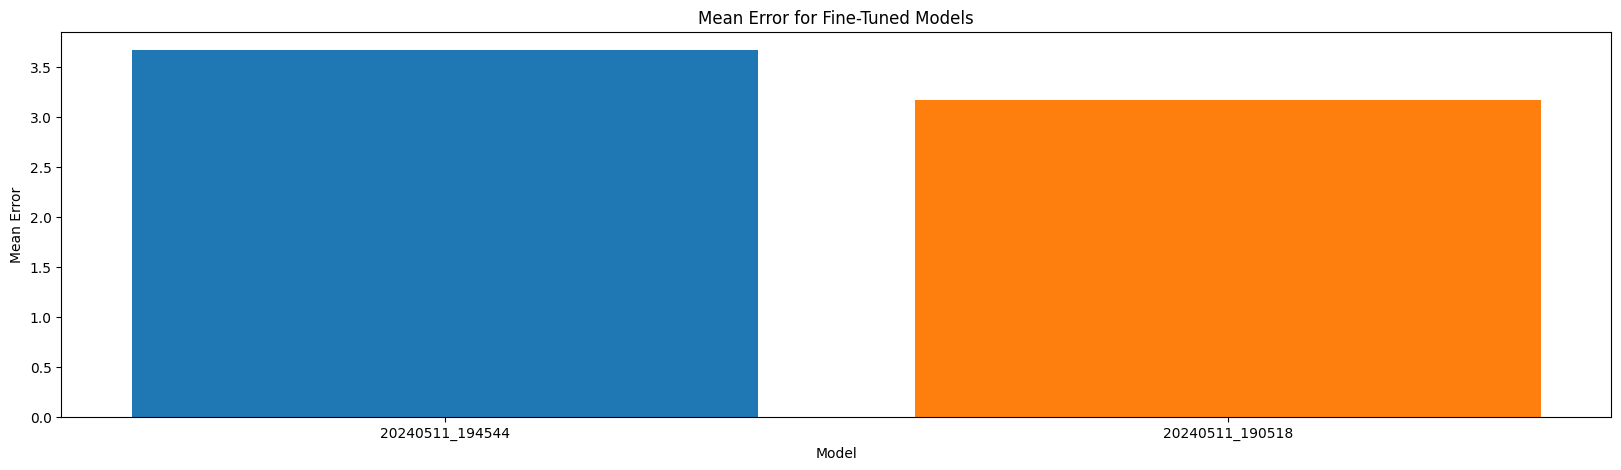

In [9]:
# Plot the pk metrics error for each model
import matplotlib.pyplot as plt

models = prediction['model'].unique()
metrics = analysis_results['metric'].unique()

fig = plt.figure(figsize=(20, 5))
for model_id in models:
    model_results = analysis_results[
        (analysis_results['model_id'] == model_id) &
        (analysis_results['metric'] == 'pk')
        ]

    # Plot the mean error for each model
    mean_error = model_results['error'].mean()
    plt.bar(model_id, mean_error, label=model_id)

plt.xlabel('Model')
plt.ylabel('Mean Error')
plt.title('Mean Error for Fine-Tuned Models')

plt.show()

In [10]:
import scipy.stats as stats

correlations = []

for model in models:
    model_data = analysis_results[analysis_results['model_id'] == model]

    for metric in metrics:
        metric_data = model_data[model_data['metric'] == metric]

        if len(metric_data) != 0:
            correlation, p_value = stats.pearsonr(metric_data['prediction'], metric_data['ground_truth'])
            rmse = ((metric_data['prediction'] - metric_data['ground_truth']) ** 2).mean() ** 0.5

            correlations.append({
                'model': model,
                'metric': metric,
                'correlation': correlation,
                'p_value': p_value,
                'rmse': rmse
            })

correlations = pd.DataFrame(correlations)
correlations

,model,metric,correlation,p_value,rmse
0,20240511_194544,pk,0.302372,0.560265,4.123106
1,20240511_194544,cp,0.138675,0.793321,6.879922
2,20240511_194544,nfcp,0.068339,0.897650,8.246211
3,20240511_194544,psd,0.303664,0.558504,15.921683
4,20240511_190518,pk,0.345271,0.502674,3.674235
5,20240511_190518,cp,0.754082,0.083278,6.595453
6,20240511_190518,nfcp,0.555064,0.252911,8.124038
7,20240511_190518,psd,0.732516,0.097752,15.427249
